In [2]:
from datetime import datetime
import time

import pandas as pd
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import RobustScaler

from statsmodels.stats.outliers_influence import variance_inflation_factor
from imblearn.over_sampling import SMOTE

import autosklearn.classification

from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsRegressor

from sklearn.metrics import plot_confusion_matrix, f1_score, accuracy_score, precision_score, recall_score
from sklearn.metrics import mean_squared_error
from math import sqrt

import matplotlib.pyplot as plt
import seaborn as sns


## EDA

In [3]:
df = pd.read_csv('../data/ordens_case_dnc_.csv', index_col='id')


In [4]:
df.head(2)

,price,order_date,due_date,opt_date,delivery_date,cidade_origem_id,regiao_origem_id,cidade_destino_id,regiao_destino_id,peso
id,,,,,,,,,,
0,107.78,2022-02-25 20:46:25+00:00,2022-03-02 00:00:00,2022-02-28 20:35:20,2022-03-02 18:03:33,2,1,25,1,23.8
1,7.47,2022-02-23 20:34:59+00:00,2022-02-24 00:00:00,2022-02-24 09:56:23,2022-02-24 15:52:40,2,1,16,4,536.0


Correção da data do campo "order_date"

In [5]:
df['order_date'] = df['order_date'].str[:-6]

In [6]:
df.head(2)


,price,order_date,due_date,opt_date,delivery_date,cidade_origem_id,regiao_origem_id,cidade_destino_id,regiao_destino_id,peso
id,,,,,,,,,,
0,107.78,2022-02-25 20:46:25,2022-03-02 00:00:00,2022-02-28 20:35:20,2022-03-02 18:03:33,2,1,25,1,23.8
1,7.47,2022-02-23 20:34:59,2022-02-24 00:00:00,2022-02-24 09:56:23,2022-02-24 15:52:40,2,1,16,4,536.0


Transformação de todas as datas para segundos

In [7]:
def getTimeSeconds(x):
    d = datetime.strptime(x, "%Y-%m-%d %H:%M:%S")
    return int(time.mktime(d.timetuple()))

df['order_date'] = df['order_date'].apply(getTimeSeconds)
df['due_date'] = df['due_date'].apply(getTimeSeconds)
df['opt_date'] = df['opt_date'].apply(getTimeSeconds)
df['delivery_date'] = df['delivery_date'].apply(getTimeSeconds)


In [8]:
len(df[df['opt_date'] < df['order_date']])


24

Remoção dos valores cujo a data de postagem é menor do que a data de compra

In [9]:
df = df[df['opt_date'] >= df['order_date']]


In [10]:
len(df[df['opt_date'] < df['order_date']])


0

Alteração de todas as horas das datas de entrega estimadas para as 18:00 do dia anterior a entrega. due_date - 21600 segundos (equivalente a 6 horas)

In [11]:
df['due_date'] = df['due_date'] - 21600


Criação das colunas "post_time" (tempo de postagem) e "elapsed_time" (tempo de entrega)

In [12]:
df['post_time'] = df['opt_date'] - df['order_date']
df['elapsed_time'] = df['delivery_date'] - df['opt_date']


In [13]:
df.head(3)


,price,order_date,due_date,opt_date,delivery_date,cidade_origem_id,regiao_origem_id,cidade_destino_id,regiao_destino_id,peso,post_time,elapsed_time
id,,,,,,,,,,,,
0,107.78,1645832785,1646168400,1646091320,1646255013,2,1,25,1,23.8,258535,163693
1,7.47,1645659299,1645650000,1645707383,1645728760,2,1,16,4,536.0,48084,21377
3,5.98,1644514477,1645045200,1645094869,1645118592,2,1,21,1,441.0,580392,23723


Criação da coluna "outcome" (resultado da entrega. 1 = correta, 0 = atraso)

In [14]:
df['outcome'] = 0
df['outcome'].iloc[df['due_date'] <= df['delivery_date']] = 1


/tmp/ipykernel_22743/1026693437.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['outcome'].iloc[df['due_date'] <= df['delivery_date']] = 1


In [15]:
df['outcome'].value_counts()

1    1289
0     482
Name: outcome, dtype: int64

In [16]:
df.head(3)

,price,order_date,due_date,opt_date,delivery_date,cidade_origem_id,regiao_origem_id,cidade_destino_id,regiao_destino_id,peso,post_time,elapsed_time,outcome
id,,,,,,,,,,,,,
0,107.78,1645832785,1646168400,1646091320,1646255013,2,1,25,1,23.8,258535,163693,1
1,7.47,1645659299,1645650000,1645707383,1645728760,2,1,16,4,536.0,48084,21377,1
3,5.98,1644514477,1645045200,1645094869,1645118592,2,1,21,1,441.0,580392,23723,1


Conversão da tipagem de todas as variáveis categóricas para o tipo "category"

In [17]:
df["cidade_origem_id"] = df["cidade_origem_id"].astype("category")
df["regiao_origem_id"] = df["regiao_origem_id"].astype("category")
df["cidade_destino_id"] = df["cidade_destino_id"].astype("category")
df["regiao_destino_id"] = df["regiao_destino_id"].astype("category")


In [18]:
df.dtypes

price                 float64
order_date              int64
due_date                int64
opt_date                int64
delivery_date           int64
cidade_origem_id     category
regiao_origem_id     category
cidade_destino_id    category
regiao_destino_id    category
peso                  float64
post_time               int64
elapsed_time            int64
outcome                 int64
dtype: object

Plot de frequência de entregues atrasados ou não (indica que os dados precisam ser balanceados)

<AxesSubplot:ylabel='Frequency'>

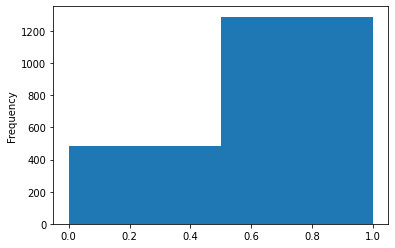

In [19]:
df['outcome'].plot.hist(bins=2)


Plot do gráfico de correlação entre variáveis preditoras (indica que algumas variáveis são extremamente correlacionadas)

<AxesSubplot:>

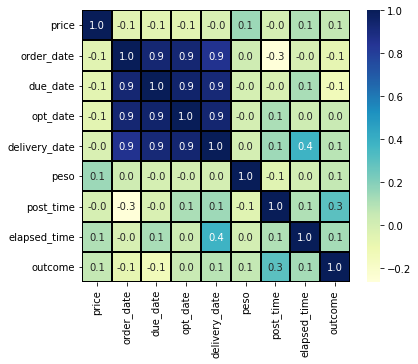

In [20]:
corr = df.corr()

plt.subplots(figsize=(6, 5))
sns.heatmap(corr, cmap='YlGnBu', annot=True, fmt=".1f",
            linecolor="black", linewidths="0.1", )


VIF (Verifica a significancia estatística das colunas. Maior ou igual a 5 indica menor significância)

In [21]:
vif_data = pd.DataFrame()
vif_data["feature"] = df.columns

# calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(df.values, i)
                   for i in range(len(df.columns))]

vif_data

/home/felipe/dev/predicao-falha-entrega-logistica/venv/lib/python3.8/site-packages/statsmodels/stats/outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


,feature,VIF
0,price,1.138052
1,order_date,inf
2,due_date,21.882778
3,opt_date,inf
4,delivery_date,inf
5,cidade_origem_id,9.559544
6,regiao_origem_id,11.650471
7,cidade_destino_id,1.179918
8,regiao_destino_id,1.133480
9,peso,1.054842


Eliminação de variáveis altamente correlacionadas

In [22]:
df.drop(columns=['order_date', 'due_date', 'opt_date', 'delivery_date', 'regiao_origem_id',
        'regiao_destino_id'], inplace=True)


<AxesSubplot:>

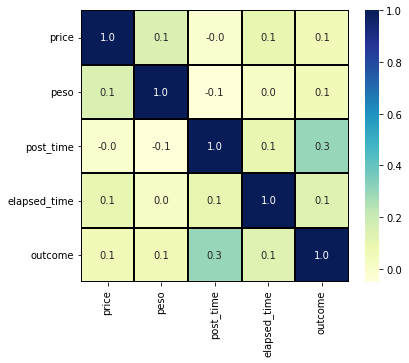

In [23]:
corr = df.corr()

plt.subplots(figsize=(6, 5))
sns.heatmap(corr, cmap='YlGnBu', annot=True, fmt=".1f",
            linecolor="black", linewidths="0.1", )


Significância estatistica do modelo revisada e corrigida

In [24]:
vif_data = pd.DataFrame()
vif_data["feature"] = df.columns

# calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(df.values, i)
                   for i in range(len(df.columns))]

vif_data


,feature,VIF
0,price,1.450139
1,cidade_origem_id,3.316187
2,cidade_destino_id,2.073115
3,peso,1.092959
4,post_time,2.210673
5,elapsed_time,1.390803
6,outcome,3.157553


## Preprocessor

Dummyficação de variáveis categóricas

In [25]:
dummy_df = pd.get_dummies(df[['cidade_origem_id',
                          'cidade_destino_id']], drop_first=True)
df = df.join(dummy_df)
df.drop(columns=['cidade_origem_id', 'cidade_destino_id'], inplace=True)


In [26]:
df.head()

,price,peso,post_time,elapsed_time,outcome,cidade_origem_id_2,cidade_origem_id_3,cidade_origem_id_4,cidade_origem_id_5,cidade_destino_id_2,...,cidade_destino_id_118,cidade_destino_id_119,cidade_destino_id_120,cidade_destino_id_121,cidade_destino_id_122,cidade_destino_id_123,cidade_destino_id_124,cidade_destino_id_125,cidade_destino_id_126,cidade_destino_id_127
id,,,,,,,,,,,,,,,,,,,,,
0,107.78,23.80,258535,163693,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,7.47,536.00,48084,21377,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,5.98,441.00,580392,23723,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,5.37,0.73,39753,21553,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,7.47,875.00,45465,26751,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Divisão do dataset em treino, validação e teste

In [27]:
X = df.drop(['outcome'], axis=1)
y = df['outcome']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

X_train = pd.DataFrame(X_train, columns=X_train.columns)
y_train = pd.Series(y_train)

X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.25, random_state=42)  # 0.25 x


Tratamento dos dados por dataset dividido (eliminação da possibilidade de vazamento de dados). Tratamentos:

1. Balanceamento de dados
2. Normalização de dados

In [28]:
def trataDados(df_dados, target):
    # Balanceamento dos dados
    sm = SMOTE(sampling_strategy='minority', random_state=7)
    df_dados, target = sm.fit_resample(df_dados, target)

    # Normalização dos dados
    df_dados[['price', 'peso', 'post_time', 'elapsed_time']] = RobustScaler(
    ).fit_transform(df_dados[['price', 'peso', 'post_time', 'elapsed_time']]).copy()

    return df_dados, target


X_train, y_train = trataDados(X_train, y_train)
X_val, y_val = trataDados(X_val, y_val)
X_test, y_test = trataDados(X_test, y_test)


In [29]:
X_train.head()


,price,peso,post_time,elapsed_time,cidade_origem_id_2,cidade_origem_id_3,cidade_origem_id_4,cidade_origem_id_5,cidade_destino_id_2,cidade_destino_id_3,...,cidade_destino_id_118,cidade_destino_id_119,cidade_destino_id_120,cidade_destino_id_121,cidade_destino_id_122,cidade_destino_id_123,cidade_destino_id_124,cidade_destino_id_125,cidade_destino_id_126,cidade_destino_id_127
0,-0.569863,0.782973,-0.342289,0.461180,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,-0.328252,-0.034274,-0.019289,-2.166061,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,-0.328252,0.714604,-0.072544,-1.696779,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,-0.569863,0.806754,0.304329,-0.294888,0,0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
4,-0.328252,-0.033798,2.204596,-1.321676,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## AutoML (testes)

In [30]:
automl = autosklearn.classification.AutoSklearnClassifier(
    time_left_for_this_task=100,
    per_run_time_limit=20)


In [31]:
automl.fit(X_train, y_train)


/home/felipe/dev/predicao-falha-entrega-logistica/venv/lib/python3.8/site-packages/autosklearn/metalearning/metalearning/meta_base.py:68: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.metafeatures = self.metafeatures.append(metafeatures)
/home/felipe/dev/predicao-falha-entrega-logistica/venv/lib/python3.8/site-packages/autosklearn/metalearning/metalearning/meta_base.py:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.algorithm_runs[metric].append(runs)


AutoSklearnClassifier(per_run_time_limit=20, time_left_for_this_task=100)

F1 Score: 88.2%
Accuracy Score: 88.22%
Precision Score: 84.86%
Recall Score: 93.05%


/home/felipe/dev/predicao-falha-entrega-logistica/venv/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


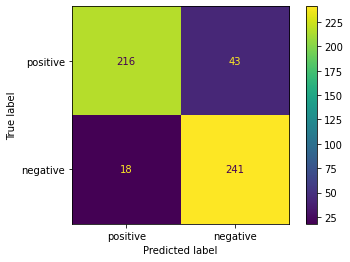

In [32]:
predictAutoML = automl.predict(X_val)

f1 = round(f1_score(y_val, predictAutoML, average='macro')*100, 2)
accuracy = round(accuracy_score(y_val, predictAutoML)*100, 2)
precision = round(precision_score(y_val, predictAutoML)*100, 2)
recall = round(recall_score(y_val, predictAutoML)*100, 2)

print(f"F1 Score: {f1}%")
print(f"Accuracy Score: {accuracy}%")
print(f"Precision Score: {precision}%")
print(f"Recall Score: {recall}%")

plot_confusion_matrix(automl, X_val, y_val, display_labels=[
                      "positive", "negative"], values_format="d")
plt.grid(False)
plt.show()


F1 Score: 89.66%
Accuracy Score: 89.68%
Precision Score: 86.5%
Recall Score: 94.05%


/home/felipe/dev/predicao-falha-entrega-logistica/venv/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


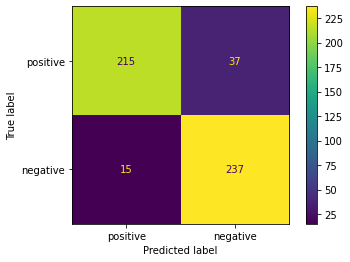

In [33]:
predictAutoML = automl.predict(X_test)

f1 = round(f1_score(y_test, predictAutoML, average='macro')*100, 2)
accuracy = round(accuracy_score(y_test, predictAutoML)*100, 2)
precision = round(precision_score(y_test, predictAutoML)*100, 2)
recall = round(recall_score(y_test, predictAutoML)*100, 2)

print(f"F1 Score: {f1}%")
print(f"Accuracy Score: {accuracy}%")
print(f"Precision Score: {precision}%")
print(f"Recall Score: {recall}%")

plot_confusion_matrix(automl, X_test, y_test, display_labels=[
                      "positive", "negative"], values_format="d")
plt.grid(False)
plt.show()

plt.show()


In [34]:
pd.DataFrame(automl.show_models()).transpose()


,model_id,rank,cost,ensemble_weight,data_preprocessor,balancing,feature_preprocessor,classifier,sklearn_classifier
17,17,1,0.095331,0.08,<autosklearn.pipeline.components.data_preproce...,autosklearn.pipeline Balancing Imbalanced Clas...,<autosklearn.pipeline.components.feature_prepr...,<autosklearn.pipeline.components.classificatio...,HistGradientBoostingClassifier(early_stopping=...
16,16,2,0.099222,0.18,<autosklearn.pipeline.components.data_preproce...,autosklearn.pipeline Balancing Imbalanced Clas...,<autosklearn.pipeline.components.feature_prepr...,<autosklearn.pipeline.components.classificatio...,"(ExtraTreeClassifier(max_features=9, min_sampl..."
14,14,3,0.101167,0.04,<autosklearn.pipeline.components.data_preproce...,autosklearn.pipeline Balancing Imbalanced Clas...,<autosklearn.pipeline.components.feature_prepr...,<autosklearn.pipeline.components.classificatio...,HistGradientBoostingClassifier(early_stopping=...
2,2,4,0.108949,0.08,<autosklearn.pipeline.components.data_preproce...,autosklearn.pipeline Balancing Imbalanced Clas...,<autosklearn.pipeline.components.feature_prepr...,<autosklearn.pipeline.components.classificatio...,"(DecisionTreeClassifier(max_features=10, rando..."
11,11,5,0.108949,0.12,<autosklearn.pipeline.components.data_preproce...,autosklearn.pipeline Balancing Imbalanced Clas...,<autosklearn.pipeline.components.feature_prepr...,<autosklearn.pipeline.components.classificatio...,"(DecisionTreeClassifier(max_features=2, random..."
3,3,6,0.118677,0.04,<autosklearn.pipeline.components.data_preproce...,autosklearn.pipeline Balancing Imbalanced Clas...,<autosklearn.pipeline.components.feature_prepr...,<autosklearn.pipeline.components.classificatio...,"(DecisionTreeClassifier(criterion='entropy', m..."
4,4,7,0.120623,0.06,<autosklearn.pipeline.components.data_preproce...,autosklearn.pipeline Balancing Imbalanced Clas...,<autosklearn.pipeline.components.feature_prepr...,<autosklearn.pipeline.components.classificatio...,"KNeighborsClassifier(n_neighbors=6, p=1, weigh..."
13,13,8,0.126459,0.12,<autosklearn.pipeline.components.data_preproce...,autosklearn.pipeline Balancing Imbalanced Clas...,<autosklearn.pipeline.components.feature_prepr...,<autosklearn.pipeline.components.classificatio...,"(DecisionTreeClassifier(max_features=2, min_sa..."
15,15,9,0.126459,0.04,<autosklearn.pipeline.components.data_preproce...,autosklearn.pipeline Balancing Imbalanced Clas...,<autosklearn.pipeline.components.feature_prepr...,<autosklearn.pipeline.components.classificatio...,HistGradientBoostingClassifier(early_stopping=...
6,6,10,0.167315,0.24,<autosklearn.pipeline.components.data_preproce...,autosklearn.pipeline Balancing Imbalanced Clas...,<autosklearn.pipeline.components.feature_prepr...,<autosklearn.pipeline.components.classificatio...,"(DecisionTreeClassifier(max_depth=2, random_st..."


## Modeling

### Decision Tree

Treino

In [35]:
dtc_model = DecisionTreeClassifier()
dtc_model.fit(X_train, y_train)


DecisionTreeClassifier()

Validação (tunning de hyperparâmetros)

F1 Score: 72.97%
Accuracy Score: 72.97%
Precision Score: 72.45%
Recall Score: 74.13%


/home/felipe/dev/predicao-falha-entrega-logistica/venv/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


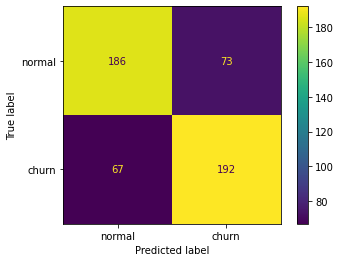

In [36]:
predict_DTC = dtc_model.predict(X_val)

f1 = round(f1_score(y_val, predict_DTC, average='macro')*100, 2)
accuracy = round(accuracy_score(y_val, predict_DTC)*100, 2)
precision = round(precision_score(y_val, predict_DTC)*100, 2)
recall = round(recall_score(y_val, predict_DTC)*100, 2)

print(f"F1 Score: {f1}%")
print(f"Accuracy Score: {accuracy}%")
print(f"Precision Score: {precision}%")
print(f"Recall Score: {recall}%")

plot_confusion_matrix(dtc_model, X_val, y_val, display_labels=[
                      "normal", "churn"], values_format="d")
plt.grid(False)
plt.show()


Teste

F1 Score: 72.97%
Accuracy Score: 72.97%
Precision Score: 72.45%
Recall Score: 74.13%


/home/felipe/dev/predicao-falha-entrega-logistica/venv/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


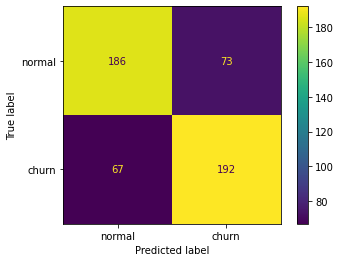

In [37]:
predict_DTC = dtc_model.predict(X_val)

f1 = round(f1_score(y_val, predict_DTC, average='macro')*100, 2)
accuracy = round(accuracy_score(y_val, predict_DTC)*100, 2)
precision = round(precision_score(y_val, predict_DTC)*100, 2)
recall = round(recall_score(y_val, predict_DTC)*100, 2)

print(f"F1 Score: {f1}%")
print(f"Accuracy Score: {accuracy}%")
print(f"Precision Score: {precision}%")
print(f"Recall Score: {recall}%")

plot_confusion_matrix(dtc_model, X_val, y_val, display_labels=[
                      "normal", "churn"], values_format="d")
plt.grid(False)
plt.show()


### KNN

Treino

In [38]:
knn_model = KNeighborsRegressor(3)
knn_model.fit(X_train, y_train)


KNeighborsRegressor(n_neighbors=3)

Validação (tunning de hyperparâmetros)

In [39]:
predict_KNN = knn_model.predict(X_val)

mse = mean_squared_error(y_val, predict_KNN)
rmse = sqrt(mse)
rmse


0.39244254867579537

Teste

In [40]:
predict_KNN = knn_model.predict(X_test)

mse = mean_squared_error(y_test, predict_KNN)
rmse = sqrt(mse)
rmse


0.3782559998346817

### Multilayer Perceptron

Treino

In [41]:
mlp_model = MLPClassifier(hidden_layer_sizes=(6, 5),
                          random_state=5,
                          verbose=True,
                          learning_rate_init=0.01)
mlp_model.fit(X_train, y_train)


Iteration 1, loss = 0.75771269
Iteration 2, loss = 0.67588543
Iteration 3, loss = 0.60287458
Iteration 4, loss = 0.53664665
Iteration 5, loss = 0.47057948
Iteration 6, loss = 0.40545076
Iteration 7, loss = 0.35195863
Iteration 8, loss = 0.30754393
Iteration 9, loss = 0.28170686
Iteration 10, loss = 0.25035579
Iteration 11, loss = 0.24763504
Iteration 12, loss = 0.22808614
Iteration 13, loss = 0.21720737
Iteration 14, loss = 0.20721826
Iteration 15, loss = 0.21108323
Iteration 16, loss = 0.20633333
Iteration 17, loss = 0.18845556
Iteration 18, loss = 0.17577592
Iteration 19, loss = 0.17270838
Iteration 20, loss = 0.16970795
Iteration 21, loss = 0.16612093
Iteration 22, loss = 0.15877663
Iteration 23, loss = 0.16084029
Iteration 24, loss = 0.15610471
Iteration 25, loss = 0.15721441
Iteration 26, loss = 0.15512610
Iteration 27, loss = 0.14963125
Iteration 28, loss = 0.14998582
Iteration 29, loss = 0.15185115
Iteration 30, loss = 0.15042941
Iteration 31, loss = 0.14398790
Iteration 32, los

MLPClassifier(hidden_layer_sizes=(6, 5), learning_rate_init=0.01,
              random_state=5, verbose=True)

Validação (tunning de hyperparâmetros)

F1 Score: 93.63%
Accuracy Score: 93.63%
Precision Score: 92.16%
Recall Score: 95.37%


/home/felipe/dev/predicao-falha-entrega-logistica/venv/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


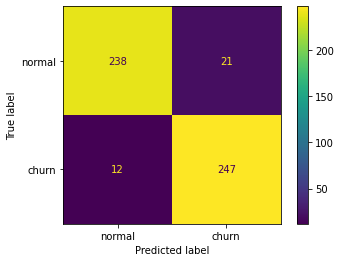

In [42]:
predict_MLP = mlp_model.predict(X_val)

f1 = round(f1_score(y_val, predict_MLP, average='macro')*100, 2)
accuracy = round(accuracy_score(y_val, predict_MLP)*100, 2)
precision = round(precision_score(y_val, predict_MLP)*100, 2)
recall = round(recall_score(y_val, predict_MLP)*100, 2)

print(f"F1 Score: {f1}%")
print(f"Accuracy Score: {accuracy}%")
print(f"Precision Score: {precision}%")
print(f"Recall Score: {recall}%")

plot_confusion_matrix(mlp_model, X_val, y_val, display_labels=[
                      "normal", "churn"], values_format="d")
plt.grid(False)
plt.show()

Teste

F1 Score: 93.65%
Accuracy Score: 93.65%
Precision Score: 93.65%
Recall Score: 93.65%


/home/felipe/dev/predicao-falha-entrega-logistica/venv/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


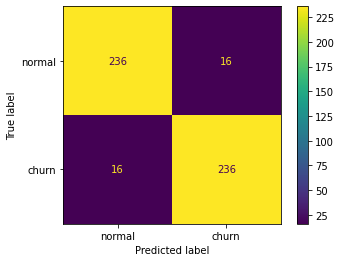

In [43]:
predict_MLP = mlp_model.predict(X_test)

f1 = round(f1_score(y_test, predict_MLP, average='macro')*100, 2)
accuracy = round(accuracy_score(y_test, predict_MLP)*100, 2)
precision = round(precision_score(y_test, predict_MLP)*100, 2)
recall = round(recall_score(y_test, predict_MLP)*100, 2)

print(f"F1 Score: {f1}%")
print(f"Accuracy Score: {accuracy}%")
print(f"Precision Score: {precision}%")
print(f"Recall Score: {recall}%")

plot_confusion_matrix(mlp_model, X_test, y_test, display_labels=[
                      "normal", "churn"], values_format="d")
plt.grid(False)
plt.show()
